In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

ModuleNotFoundError: No module named 'catboost'

In [21]:
# Đọc dữ liệu từ file Excel
dataset = pd.read_excel("HousePricePrediction.xlsx")

In [22]:
# Hiển thị 5 dòng đầu tiên của dữ liệu
dataset.head(5)

,Id,MSSubClass,MSZoning,LotArea,LotConfig,BldgType,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,BsmtFinSF2,TotalBsmtSF,SalePrice
0,0,60,RL,8450,Inside,1Fam,5,2003,2003,VinylSd,0.0,856.0,208500.0
1,1,20,RL,9600,FR2,1Fam,8,1976,1976,MetalSd,0.0,1262.0,181500.0
2,2,60,RL,11250,Inside,1Fam,5,2001,2002,VinylSd,0.0,920.0,223500.0
3,3,70,RL,9550,Corner,1Fam,5,1915,1970,Wd Sdng,0.0,756.0,140000.0
4,4,60,RL,14260,FR2,1Fam,5,2000,2000,VinylSd,0.0,1145.0,250000.0


In [23]:
dataset.shape

(2919, 13)

In [24]:
# Phân loại các cột kiểu dữ liệu
obj = (dataset.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Số lượng biến phân loại:", len(object_cols))

int_ = (dataset.dtypes == 'int64')
num_cols = list(int_[int_].index)
print("Số lượng biến kiểu số nguyên:", len(num_cols))

fl = (dataset.dtypes == 'float64')
fl_cols = list(fl[fl].index)
print("Số lượng biến kiểu số thực:", len(fl_cols))

Số lượng biến phân loại: 4
Số lượng biến kiểu số nguyên: 6
Số lượng biến kiểu số thực: 3


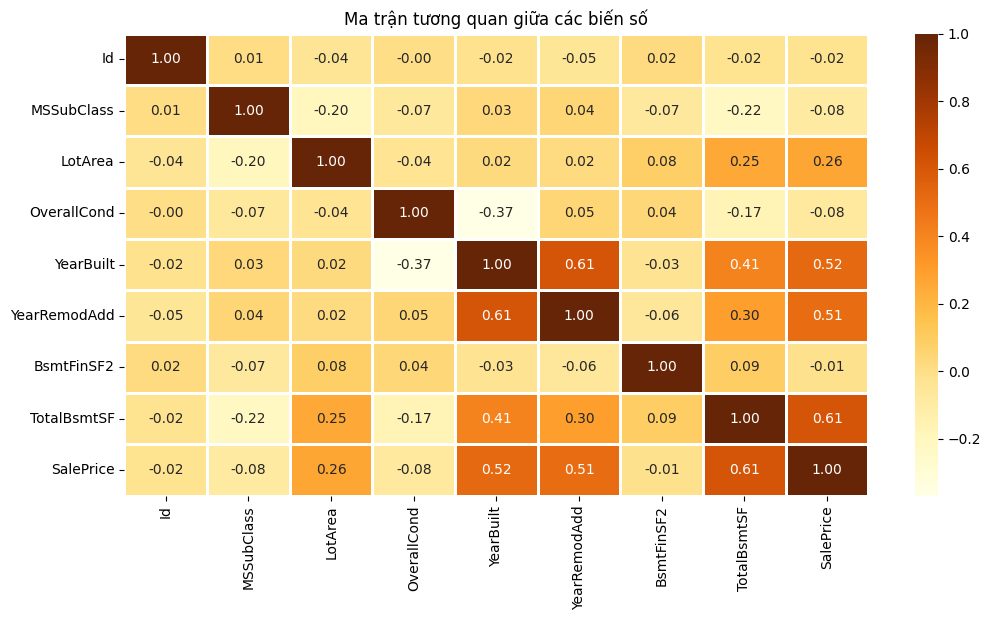

In [25]:
# Chọn các biến số để phân tích tương quan
numerical_dataset = dataset.select_dtypes(include=['number'])

# Vẽ biểu đồ ma trận tương quan
plt.figure(figsize=(12, 6))
sns.heatmap(numerical_dataset.corr(), cmap='YlOrBr', fmt='.2f', linewidths=2, annot=True)
plt.title('Ma trận tương quan giữa các biến số')
plt.show()

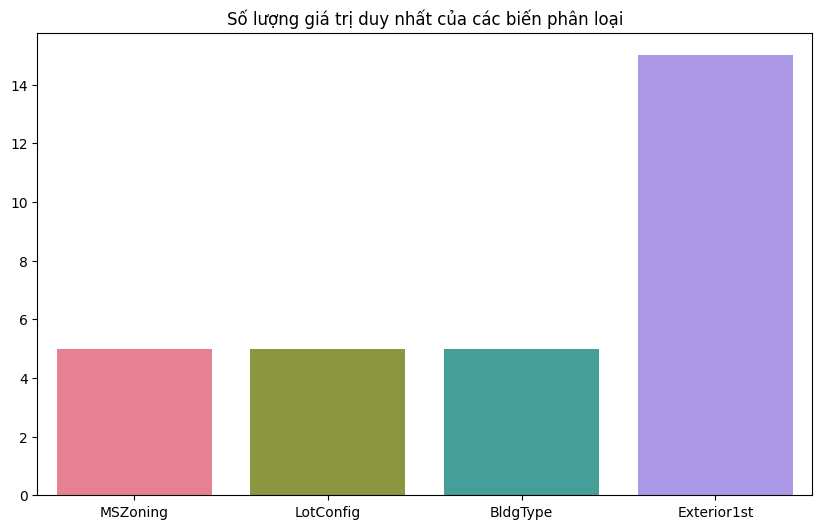

In [26]:
# Số lượng giá trị duy nhất trong các biến phân loại
unique_values = [dataset[col].nunique() for col in object_cols]

plt.figure(figsize=(10, 6))
plt.title('Số lượng giá trị duy nhất của các biến phân loại')
sns.barplot(x=object_cols, y=unique_values, hue=object_cols, palette='husl', legend=False)
plt.show()

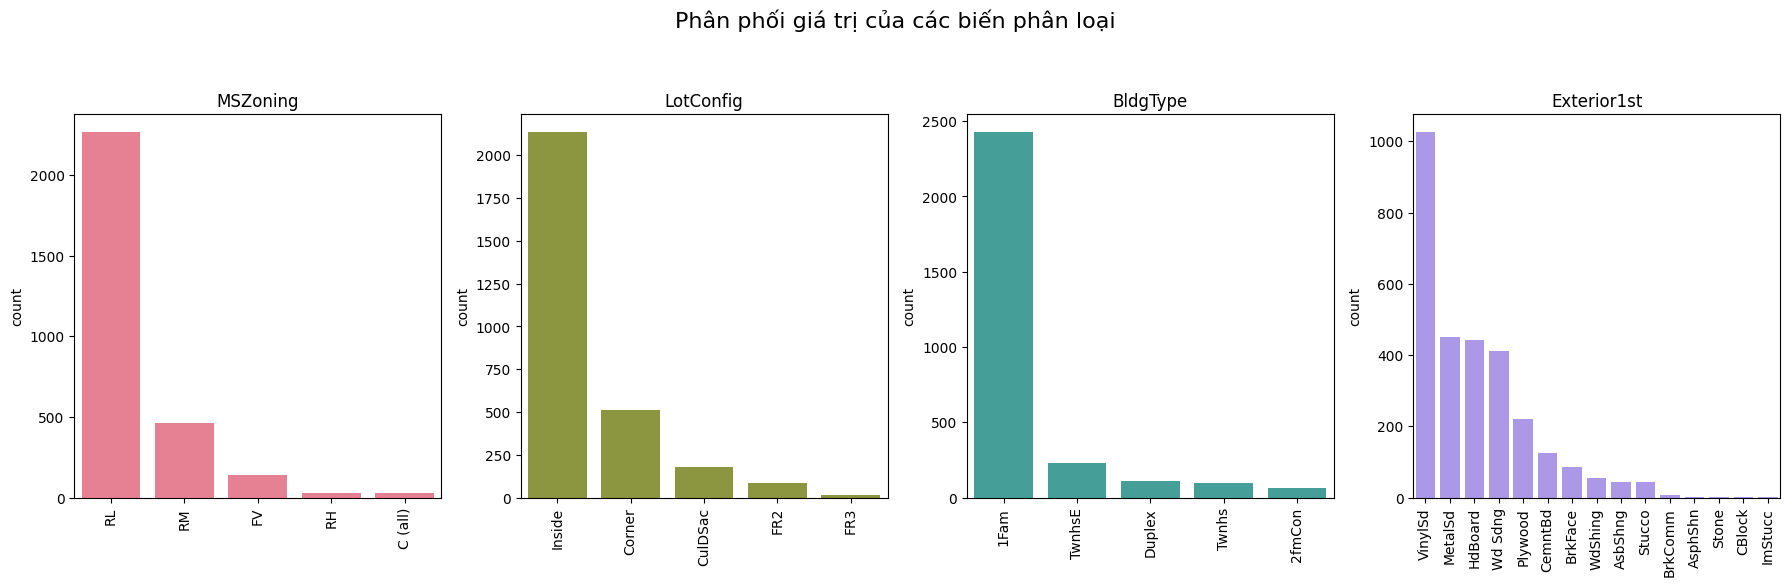

In [27]:
# Danh sách các màu sắc khác nhau
colors = sns.color_palette("husl", len(object_cols))

# Vẽ biểu đồ phân phối giá trị của các biến phân loại
fig, axes = plt.subplots(nrows=(len(object_cols) // 4) + 1, ncols=4, figsize=(18, 10))
axes = axes.flatten()

for index, col in enumerate(object_cols):
    y = dataset[col].value_counts()
    sns.barplot(x=list(y.index), y=y, ax=axes[index], color=colors[index])
    axes[index].set_title(col)
    axes[index].tick_params(axis='x', rotation=90)

for i in range(index + 1, len(axes)):
    axes[i].set_visible(False)

fig.suptitle('Phân phối giá trị của các biến phân loại', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [28]:
# Loại bỏ cột 'Id' không cần thiết
dataset.drop(['Id'], axis=1, inplace=True)

In [29]:
print(dataset.isnull().sum())

MSSubClass         0
MSZoning           4
LotArea            0
LotConfig          0
BldgType           0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
Exterior1st        1
BsmtFinSF2         1
TotalBsmtSF        1
SalePrice       1459
dtype: int64


In [30]:
dataset['SalePrice'] = dataset['SalePrice'].fillna(dataset['SalePrice'].mean())

In [31]:
# Loại bỏ các dòng còn thiếu dữ liệu
new_dataset = dataset.dropna()
print("Số lượng giá trị thiếu sau khi xử lý:")
print(new_dataset.isnull().sum())

Số lượng giá trị thiếu sau khi xử lý:
MSSubClass      0
MSZoning        0
LotArea         0
LotConfig       0
BldgType        0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
Exterior1st     0
BsmtFinSF2      0
TotalBsmtSF     0
SalePrice       0
dtype: int64


In [32]:
# Mã hóa các biến phân loại
s = (new_dataset.dtypes == 'object')
object_cols = list(s[s].index)
print("Các biến phân loại:", object_cols)
print("Số lượng biến phân loại:", len(object_cols))

Các biến phân loại: ['MSZoning', 'LotConfig', 'BldgType', 'Exterior1st']
Số lượng biến phân loại: 4


In [33]:
OH_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
OH_cols = pd.DataFrame(OH_encoder.fit_transform(new_dataset[object_cols]))
OH_cols.index = new_dataset.index
OH_cols.columns = OH_encoder.get_feature_names_out()

# Tạo dataset cuối cùng sau khi mã hóa
final_dataset = new_dataset.drop(object_cols, axis=1)
final_dataset = pd.concat([final_dataset, OH_cols], axis=1)

In [34]:
# Tách dữ liệu thành X (đầu vào) và Y (đầu ra)
X = final_dataset.drop(['SalePrice'], axis=1)
Y = final_dataset['SalePrice']

# Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

In [35]:
# Huấn luyện mô hình Support Vector Regression
model_SVR = svm.SVR()
model_SVR.fit(X_train, Y_train)
Y_pred_svr = model_SVR.predict(X_valid)
svr_mape = mean_absolute_percentage_error(Y_valid, Y_pred_svr)
print("MAPE của mô hình SVR:", svr_mape)

MAPE của mô hình SVR: 0.1870512931870423


In [36]:
# Huấn luyện mô hình Random Forest Regressor
model_RFR = RandomForestRegressor(n_estimators=10)
model_RFR.fit(X_train, Y_train)
Y_pred_rfr = model_RFR.predict(X_valid)
rfr_mape = mean_absolute_percentage_error(Y_valid, Y_pred_rfr)
print("MAPE của mô hình RFR:", rfr_mape)

MAPE của mô hình RFR: 0.18765725363037974


In [37]:
# Huấn luyện mô hình Linear Regression
model_LR = LinearRegression()
model_LR.fit(X_train, Y_train)
Y_pred_lr = model_LR.predict(X_valid)
lr_mape = mean_absolute_percentage_error(Y_valid, Y_pred_lr)
print("MAPE của mô hình Linear Regression:", lr_mape)

MAPE của mô hình Linear Regression: 0.187416838415999


In [38]:
# Huấn luyện mô hình CatBoost Regressor
cb_model = CatBoostRegressor(verbose=0)
cb_model.fit(X_train, Y_train)
preds_cb = cb_model.predict(X_valid)
cb_r2_score = r2_score(Y_valid, preds_cb)
print("R2 Score của mô hình CatBoost:", cb_r2_score)
cb_mape = mean_absolute_percentage_error(Y_valid, preds_cb)
print("MAPE của mô hình CatBoost:", cb_mape)
# Tạo scorer cho MAPE (Mean Absolute Percentage Error)
def mape_scorer(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

# Tạo mô hình CatBoost
cb_model = CatBoostRegressor(loss_function='MAE', verbose=0)

# Sử dụng K-Fold Cross-Validation
cv_r2_scores = cross_val_score(cb_model, X_train, Y_train, scoring='r2', cv=5)
cv_mape_scores = cross_val_score(cb_model, X_train, Y_train, scoring=make_scorer(mape_scorer, greater_is_better=False), cv=5)

# Hiển thị kết quả
print("R2 Score trung bình sau Cross-Validation:", cv_r2_scores.mean())
print("MAPE trung bình sau Cross-Validation:", -cv_mape_scores.mean())  # Vì MAPE trả về giá trị âm

R2 Score của mô hình CatBoost: 0.38351169878113034
MAPE của mô hình CatBoost: 0.18178925297425216
R2 Score trung bình sau Cross-Validation: 0.21890151257662205
MAPE trung bình sau Cross-Validation: 0.17668807316732557


In [39]:
# Huấn luyện mô hình K-Nearest Neighbors Regressor
model_KNN = KNeighborsRegressor(n_neighbors=20)
model_KNN.fit(X_train, Y_train)
Y_pred_knn = model_KNN.predict(X_valid)
knn_mape = mean_absolute_percentage_error(Y_valid, Y_pred_knn)
print("MAPE của mô hình KNN:", knn_mape)

MAPE của mô hình KNN: 0.19858634990714832


In [40]:
# Huấn luyện mô hình Decision Tree Regressor
model_DT = DecisionTreeRegressor(random_state=0)
model_DT.fit(X_train, Y_train)
Y_pred_dt = model_DT.predict(X_valid)
dt_mape = mean_absolute_percentage_error(Y_valid, Y_pred_dt)
print("MAPE của mô hình Decision Tree:", dt_mape)

MAPE của mô hình Decision Tree: 0.22332073917310402


In [41]:
# Huấn luyện mô hình Gradient Boosting Regressor
model_GBR = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)
model_GBR.fit(X_train, Y_train)
Y_pred_gbr = model_GBR.predict(X_valid)
gbr_mape = mean_absolute_percentage_error(Y_valid, Y_pred_gbr)
print("MAPE của mô hình Gradient Boosting:", gbr_mape)

MAPE của mô hình Gradient Boosting: 0.1878335615561105


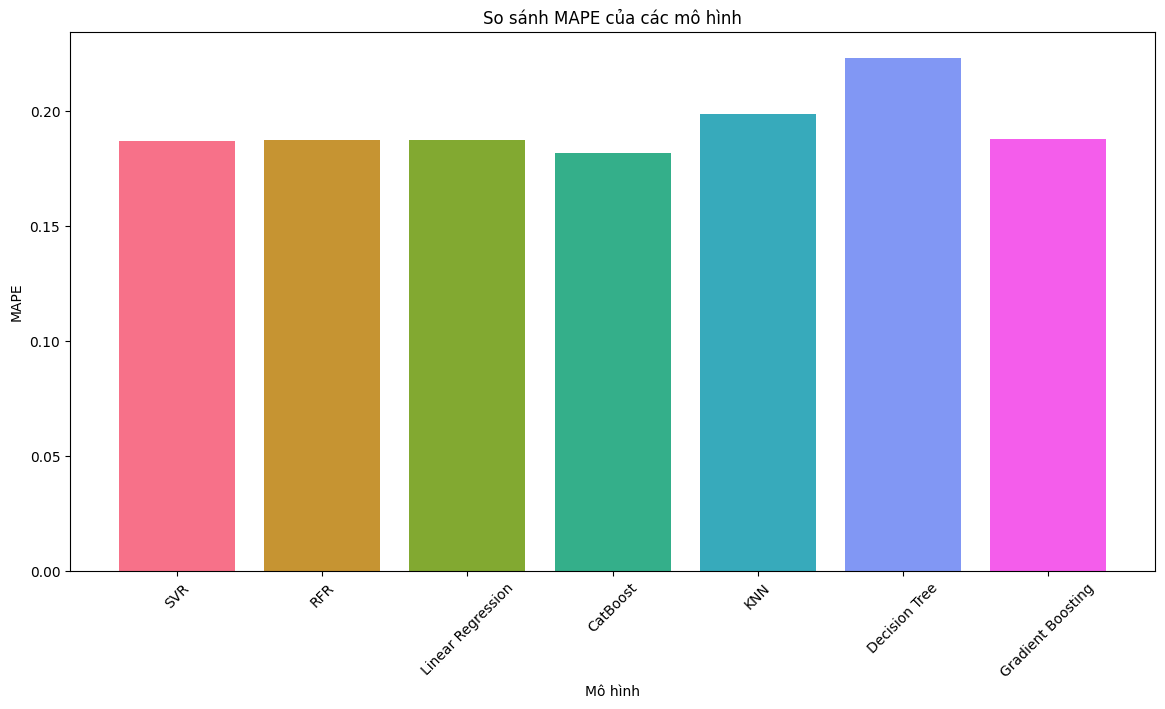

In [42]:
# So sánh kết quả của các mô hình
models = ['SVR', 'RFR', 'Linear Regression', 'CatBoost', 'KNN', 'Decision Tree', 'Gradient Boosting']
mape_scores = [svr_mape, rfr_mape, lr_mape, cb_mape, knn_mape, dt_mape, gbr_mape]

# Danh sách các màu sắc khác nhau
colors = sns.color_palette("husl", len(models))

# Vẽ biểu đồ so sánh MAPE giữa các mô hình
plt.figure(figsize=(14, 7))
plt.bar(models, mape_scores, color=colors)
plt.title('So sánh MAPE của các mô hình')
plt.ylabel('MAPE')
plt.xlabel('Mô hình')
plt.xticks(rotation=45)
plt.show()

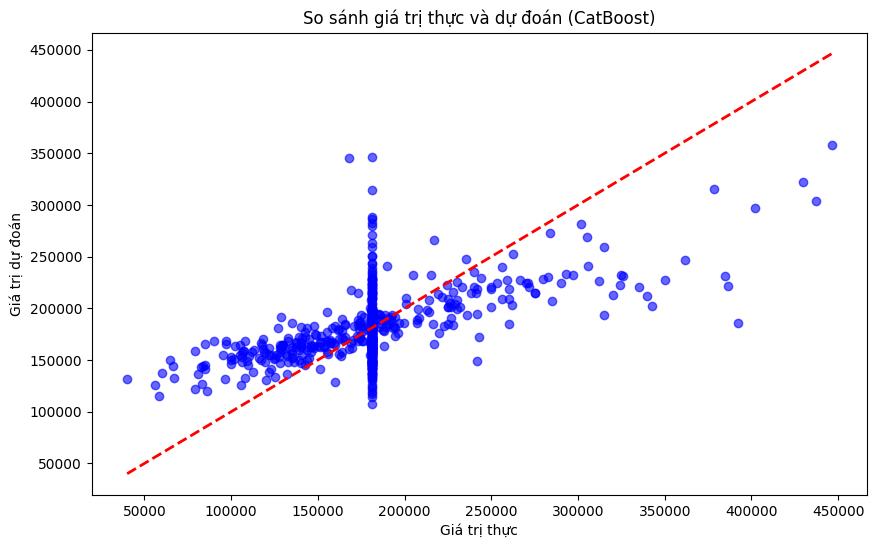

In [43]:
# Vẽ biểu đồ so sánh giá trị thực và dự đoán của mô hình tốt nhất (CatBoost)
plt.figure(figsize=(10, 6))
plt.scatter(Y_valid, preds_cb, alpha=0.6, color='blue')
plt.plot([Y_valid.min(), Y_valid.max()], [Y_valid.min(), Y_valid.max()], '--', lw=2, color='red')
plt.title('So sánh giá trị thực và dự đoán (CatBoost)')
plt.xlabel('Giá trị thực')
plt.ylabel('Giá trị dự đoán')
plt.show()
